# Ahmed's first question: Which aerospace and defense stocks have shown the most consistent positive price momentum over the last 6 months?

# Data Project: Aerospace & Defense Stocks Analysis

This notebook analyzes the most consistent momentum stocks in the Aerospace & Defense sector over the last 6 months.

In [1]:
import re
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
import os
from fpdf import FPDF

plt.style.use("dark_background")


### Step 1: Load Ticker Symbols
Here, we load the list of ticker symbols for the aerospace and defense companies.


In [2]:
file_url = "https://drive.google.com/uc?export=download&id=1AmsQ95PffFlcoCkINd8iCxmLYdT1yIQJ"
df = pd.read_csv(file_url)

if 'Symbol' not in df.columns:
    raise ValueError("CSV file must contain a 'Symbol' column.")

symbols = df['Symbol'].dropna().tolist()
filtered_tickers = [ticker for ticker in symbols if re.match(r'^[A-Z0-9]+$', ticker)]


### Step 2: Download 6-Month Stock Data
Now, we download the stock data for the tickers from Yahoo Finance.


In [3]:
print("Downloading 6-month stock data...")
ohlc = yf.download(filtered_tickers, period="6mo", auto_adjust=True)["Close"]
ohlc = ohlc.dropna(axis=1, how='all')


[*********************100%***********************]  60 of 60 completed


### Step 3: Calculate Daily Returns, Consistency Ratio, and Volatility
We calculate the daily returns and analyze the consistency of the stock momentum based on positive return days and volatility.


In [4]:
daily_returns = ohlc.pct_change()
positive_days_ratio = (daily_returns > 0).sum() / daily_returns.count()
volatility = daily_returns.std()


C:\Users\Ahmed's PC\AppData\Local\Temp\ipykernel_7800\3321046566.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = ohlc.pct_change()


### Step 4: Combine Scores
Now, we combine the positive return ratio and volatility into a single DataFrame to analyze momentum consistency.


In [5]:
consistency_df = pd.DataFrame({
    "Ticker": positive_days_ratio.index,
    "Positive Return Ratio": positive_days_ratio.values,
    "Volatility": volatility[positive_days_ratio.index].values
})


### Step 5: Classify Momentum Type
We classify the stocks into "Consistent & Stable", "Consistent but Volatile", or "Inconsistent" based on their positive return ratio and volatility.


In [6]:
def classify_momentum(row):
    if row['Positive Return Ratio'] > 0.6 and row['Volatility'] < 0.02:
        return "Consistent & Stable"
    elif row['Positive Return Ratio'] > 0.6:
        return "Consistent but Volatile"
    else:
        return "Inconsistent"

consistency_df["Momentum Type"] = consistency_df.apply(classify_momentum, axis=1)
consistency_df = consistency_df.sort_values(by="Positive Return Ratio", ascending=False)
consistency_df.to_csv("momentum_consistency_scores.csv", index=False)


### Step 6: Display Top 10 Most Consistent Momentum Stocks
Let's display the top 10 most consistent momentum stocks.


In [7]:
print("\nTop 10 Most Consistent Momentum Stocks:")
print(consistency_df.head(10))



Top 10 Most Consistent Momentum Stocks:
   Ticker  Positive Return Ratio  Volatility            Momentum Type
45  RNMBY               0.653226    0.036095  Consistent but Volatile
18  FINMY               0.612903    0.033274  Consistent but Volatile
16   ESLT               0.604839    0.021143  Consistent but Volatile
44  RNMBF               0.596774    0.039698             Inconsistent
50  SAABY               0.564516    0.036723             Inconsistent
52  SAFRY               0.556452    0.019296             Inconsistent
58  THLLY               0.548387    0.029655             Inconsistent
37    NOC               0.532258    0.016098             Inconsistent
19     GD               0.532258    0.016887             Inconsistent
17  FINMF               0.524194    0.039707             Inconsistent


### Step 7: Generate Heatmap of Daily Returns (Top 10)
Now, let's generate a heatmap for the top 10 most consistent momentum stocks to visualize their daily returns.


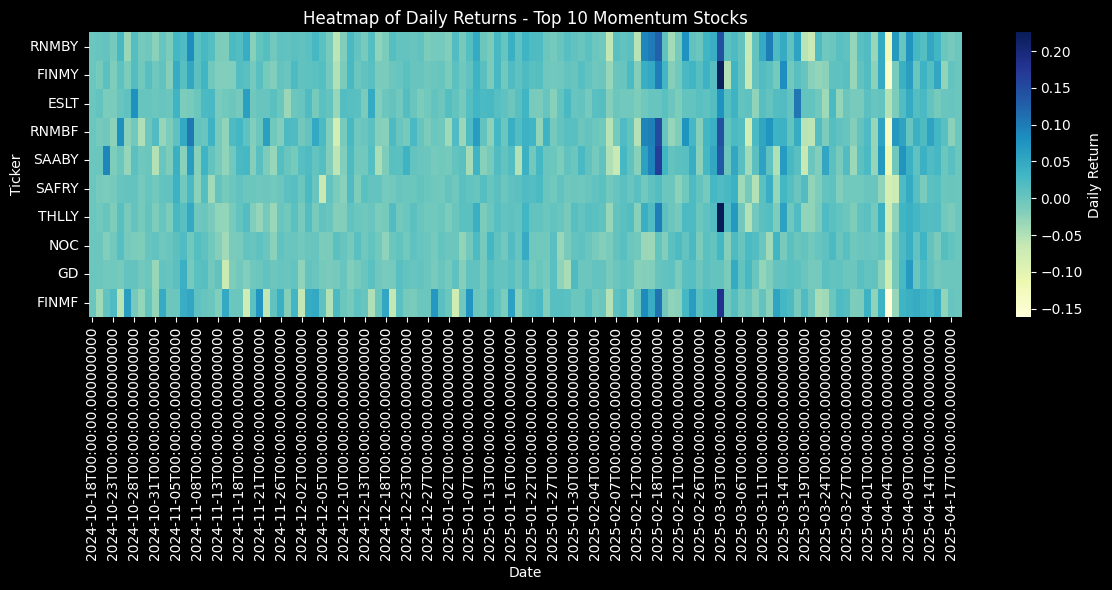

In [8]:
top_10_tickers = consistency_df.head(10)["Ticker"]
heatmap_data = daily_returns[top_10_tickers].fillna(0).T
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Daily Return'})
plt.title("Heatmap of Daily Returns - Top 10 Momentum Stocks")
plt.tight_layout()
plt.savefig("top_10_heatmap.png")
plt.show()  # Display the plot within the notebook
plt.close()


### Step 8: Generate Bar Plot of Top 15 Most Consistent Momentum Stocks
We will generate a bar plot for the top 15 stocks based on their positive return ratio.


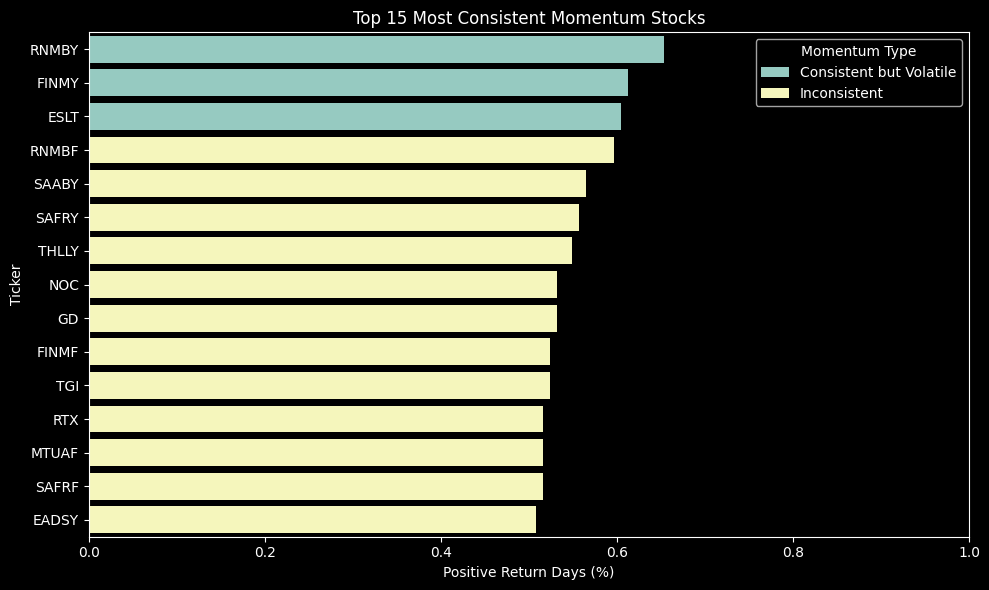

In [9]:
top_15 = consistency_df.head(15)
plt.figure(figsize=(10, 6))
sns.barplot(data=top_15, y="Ticker", x="Positive Return Ratio", hue="Momentum Type", dodge=False)
plt.title("Top 15 Most Consistent Momentum Stocks")
plt.xlabel("Positive Return Days (%)")
plt.xlim(0, 1)
plt.tight_layout()
plt.savefig("top_15_consistency_bar.png")
plt.show()  # Display the plot within the notebook
plt.close()



### Step 9: Generate Interactive Plot of Normalized Price Trends
Next, we create an interactive plot to visualize the normalized price trends for the top 10 momentum stocks.


In [10]:
fig = go.Figure()
for ticker in top_10_tickers:
    series = ohlc[ticker].dropna()
    if series.empty:
        continue
    normalized = series / series.iloc[0]
    fig.add_trace(go.Scatter(x=normalized.index, y=normalized.values, mode='lines', name=ticker))

fig.update_layout(title="Normalized Price Trends - Top 10 Momentum Stocks",
                  xaxis_title="Date", yaxis_title="Normalized Price")
fig.write_html("top_10_normalized_interactive.html")


### Step 10: Generate Summary Report
We generate a summary markdown report that includes insights from the analysis and references to the generated deliverables.


In [11]:
summary = f"""
# Aerospace & Defense Momentum Analysis

**Question:** Which aerospace and defense stocks have shown the most consistent positive price momentum over the last 6 months?

**Top Stocks:**

{consistency_df.head(10).to_markdown(index=False)}

**Insights:**
- Stocks with >60% positive days and low volatility are marked as 'Consistent & Stable'.
- Momentum is not only about gains but also about consistency and stability.
- See visuals in accompanying images and `top_10_normalized_interactive.html`.

**Files Generated:**
- `momentum_consistency_scores.csv`
- `top_10_normalized_interactive.html`
- `top_10_heatmap.png`
- `top_15_consistency_bar.png`
"""

with open("summary_report.md", "w") as f:
    f.write(summary)


### Conclusion
The analysis is complete, and all deliverables have been generated, including CSV files, plots, and interactive HTML files.
